## Data Gathering

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("utkarshsaxenadn/flower-classification-5-classes-roselilyetc")

print("Path to dataset files:", path)

100%|██████████| 949M/949M [00:28<00:00, 35.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/utkarshsaxenadn/flower-classification-5-classes-roselilyetc/versions/2


In [2]:
import os
import random
import numpy as np
import cv2
import pandas as pd

import tensorflow as tf

from google.colab import files

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

## Data Processing

In [3]:
source_dir = os.path.join(path, "Flower Classification V2/V2/")
labels = os.listdir(os.path.join(source_dir, "Training Data"))

In [4]:
combined_data = {}

for label in labels:
  combined_data[label] = [f"{source_dir}/Training Data/{label}/{x}" for x in os.listdir(f"{source_dir}/Training Data/{label}")]
  combined_data[label] += [f"{source_dir}/Validation Data/{label}/{x}" for x in os.listdir(f"{source_dir}/Validation Data/{label}")]
  combined_data[label] += [f"{source_dir}/Testing Data/{label}/{x}" for x in os.listdir(f"{source_dir}/Testing Data/{label}")]


for label in labels:
  print(f"Count {label}: {len(combined_data[label])}")

print("Total combined data",  sum([len(combined_data[label]) for label in labels]))

Count Aster: 2146
Count Lavender: 2217
Count Poppy: 2158
Count Sunflower: 2328
Count Lily: 2350
Count Daisy: 2260
Count Marigold: 2108
Count Orchid: 2202
Count Rose: 2269
Count Iris: 2317
Total combined data 22355


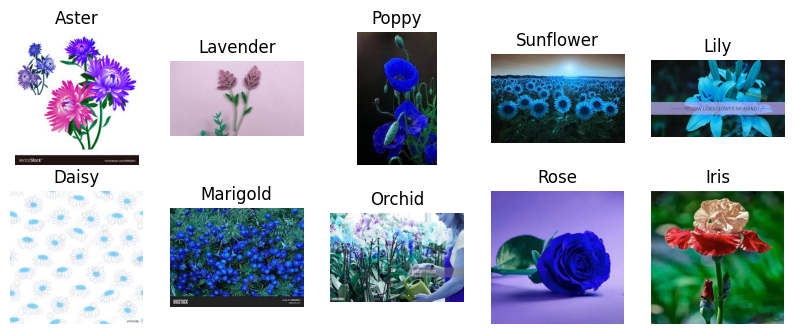

In [5]:
sample_images = [{"label": label, "img":  random.choice(combined_data[label]) } for label in labels]

figsize = (10, 10)
fig = plt.figure(figsize=figsize)

for i, img in enumerate(sample_images):
  plt.subplot(5, 5, i+1)
  plt.imshow(cv2.imread(img["img"]))
  plt.title(img["label"])
  plt.axis("off")


In [23]:
# split dataset

train_data = {}
valid_data = {}

for label in labels:
  train_data[label], valid_data[label] = train_test_split(combined_data[label], test_size=0.2, random_state=1)

In [24]:
print("Train data")
for label in labels:
  print(f"Count {label}: {len(train_data[label])}")
  print(f"Total Training",  sum([len(train_data[label]) for label in labels]))

print("\nValidation data")
for label in labels:
  print(f"Count {label}: {len(valid_data[label])}")
  print(f"Total Validation",  sum([len(valid_data[label]) for label in labels]))

Train data
Count Aster: 1716
Total Training 17880
Count Lavender: 1773
Total Training 17880
Count Poppy: 1726
Total Training 17880
Count Sunflower: 1862
Total Training 17880
Count Lily: 1880
Total Training 17880
Count Daisy: 1808
Total Training 17880
Count Marigold: 1686
Total Training 17880
Count Orchid: 1761
Total Training 17880
Count Rose: 1815
Total Training 17880
Count Iris: 1853
Total Training 17880

Validation data
Count Aster: 430
Total Validation 4475
Count Lavender: 444
Total Validation 4475
Count Poppy: 432
Total Validation 4475
Count Sunflower: 466
Total Validation 4475
Count Lily: 470
Total Validation 4475
Count Daisy: 452
Total Validation 4475
Count Marigold: 422
Total Validation 4475
Count Orchid: 441
Total Validation 4475
Count Rose: 454
Total Validation 4475
Count Iris: 464
Total Validation 4475


In [25]:
# make dataframe
training_df = pd.DataFrame()
validation_df = pd.DataFrame()

for label in labels:
  training_df = pd.concat([training_df, pd.DataFrame({"filename": train_data[label], "class": label})], ignore_index=True)
  validation_df = pd.concat([validation_df, pd.DataFrame({"filename": valid_data[label], "class": label})], ignore_index=True)

training_df.sample(10)

,filename,class
10265,/root/.cache/kagglehub/datasets/utkarshsaxenad...,Daisy
8470,/root/.cache/kagglehub/datasets/utkarshsaxenad...,Lily
7799,/root/.cache/kagglehub/datasets/utkarshsaxenad...,Lily
5685,/root/.cache/kagglehub/datasets/utkarshsaxenad...,Sunflower
2176,/root/.cache/kagglehub/datasets/utkarshsaxenad...,Lavender
6460,/root/.cache/kagglehub/datasets/utkarshsaxenad...,Sunflower
8392,/root/.cache/kagglehub/datasets/utkarshsaxenad...,Lily
3259,/root/.cache/kagglehub/datasets/utkarshsaxenad...,Lavender
5396,/root/.cache/kagglehub/datasets/utkarshsaxenad...,Sunflower
15971,/root/.cache/kagglehub/datasets/utkarshsaxenad...,Rose


## Data Preparation

In [26]:
img_height = 224
img_width = 224

batch_size = 64

In [27]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
)

valid_datagen = ImageDataGenerator(rescale=1./255)

In [28]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=training_df,
    target_size=(img_height, img_width),
    color_model="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=validation_df,
    target_size=(img_height, img_width),
    color_model="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
)

Found 17880 validated image filenames belonging to 10 classes.
Found 4475 validated image filenames belonging to 10 classes.


##Modelling

In [29]:
from tensorflow.keras.applications import MobileNet

base_model = MobileNet(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')
base_model.trainable = False

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [31]:
model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.Conv2D(128,
                           kernel_size=(3, 3),
                           activation='relu',
                           padding='same'),


    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation='softmax'),
])

In [32]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
               loss='categorical_crossentropy',
               metrics=['accuracy'])


class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
      if logs.get('accuracy') > 0.95 and logs.get('val_accuracy') > 0.95:
        print("\nReached 95% accuracy, stopping training!")
        self.model.stop_training = True

callbacks = myCallback()

In [33]:
train_generator.class_indices

{'Aster': 0,
 'Daisy': 1,
 'Iris': 2,
 'Lavender': 3,
 'Lily': 4,
 'Marigold': 5,
 'Orchid': 6,
 'Poppy': 7,
 'Rose': 8,
 'Sunflower': 9}

In [34]:
history = model.fit(train_generator,
          validation_data = valid_generator,
          callbacks=[myCallback()],
          epochs=10)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


280/280 ━━━━━━━━━━━━━━━━━━━━ 256s 853ms/step - accuracy: 0.5845 - loss: 1.3047 - val_accuracy: 0.7960 - val_loss: 0.6322
Epoch 2/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 230s 800ms/step - accuracy: 0.7776 - loss: 0.6954 - val_accuracy: 0.8277 - val_loss: 0.5601
Epoch 3/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 231s 805ms/step - accuracy: 0.8096 - loss: 0.6163 - val_accuracy: 0.8261 - val_loss: 0.5454
Epoch 4/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 266s 816ms/step - accuracy: 0.8207 - loss: 0.5560 - val_accuracy: 0.8378 - val_loss: 0.5207
Epoch 5/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 261s 811ms/step - accuracy: 0.8373 - loss: 0.5231 - val_accuracy: 0.8440 - val_loss: 0.5083
Epoch 6/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 230s 798ms/step - accuracy: 0.8426 - loss: 0.5000 - val_accuracy: 0.8534 - val_loss: 0.4864
Epoch 7/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 231s 810ms/step - accuracy: 0.8546 - loss: 0.4601 - val_accuracy: 0.8487 - val_loss: 0.5070
Epoch 8/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 232s 812ms/step - accuracy: 0.8640 - loss: 0.43

##Evaluate

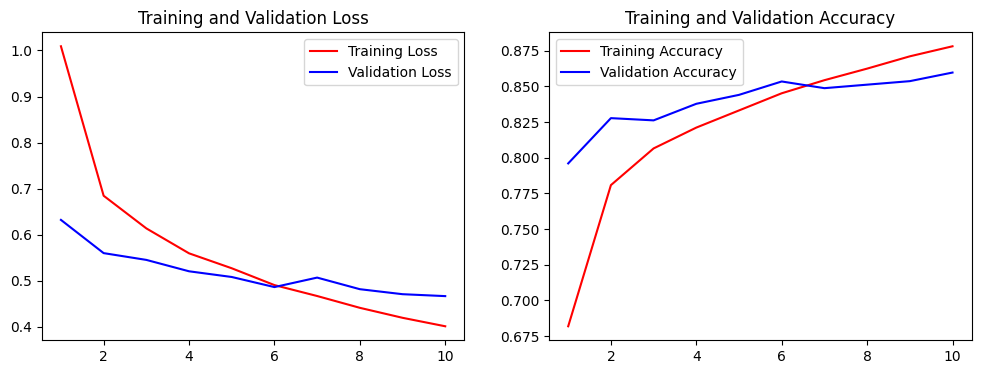

In [35]:
# visualisasi performa training dan validasi

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'r-', label='Training Loss')
plt.plot(epochs, val_loss, 'b-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel='Epochs'
plt.ylabel='Loss'
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'r-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel='Epochs'
plt.ylabel='Accuracy'
plt.legend()

plt.show()

In [36]:
# report evaluasi model
y_pred = np.argmax(model.predict(valid_generator), axis=1)
y_true = valid_generator.classes

# Calculate precision, recall, and F1 score
print(classification_report(y_true, y_pred))

# Calculate accuracy
accuracy = np.mean(y_pred == y_true)
print("Accuracy: ", accuracy)

70/70 ━━━━━━━━━━━━━━━━━━━━ 17s 222ms/step
              precision    recall  f1-score   support

           0       0.80      0.81      0.80       430
           1       0.89      0.81      0.85       452
           2       0.84      0.93      0.89       464
           3       0.86      0.88      0.87       444
           4       0.84      0.86      0.85       470
           5       0.85      0.80      0.82       422
           6       0.88      0.80      0.84       441
           7       0.87      0.90      0.88       432
           8       0.90      0.88      0.89       454
           9       0.87      0.93      0.90       466

    accuracy                           0.86      4475
   macro avg       0.86      0.86      0.86      4475
weighted avg       0.86      0.86      0.86      4475

Accuracy:  0.8596648044692737


In [37]:
val_loss, val_accuracy = model.evaluate(valid_generator)

print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

70/70 ━━━━━━━━━━━━━━━━━━━━ 18s 264ms/step - accuracy: 0.8531 - loss: 0.4964
Validation Loss: 0.46681520342826843
Validation Accuracy: 0.859664797782898


In [48]:
from tensorflow.keras.preprocessing import image

Saving Daisy Flower.jpeg to Daisy Flower.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Daisy Flower.jpeg
[[0.00634569 0.13768487 0.03177172 0.00067675 0.0714407  0.35701963
  0.00694989 0.29118747 0.00110985 0.0958134 ]]
Daisy


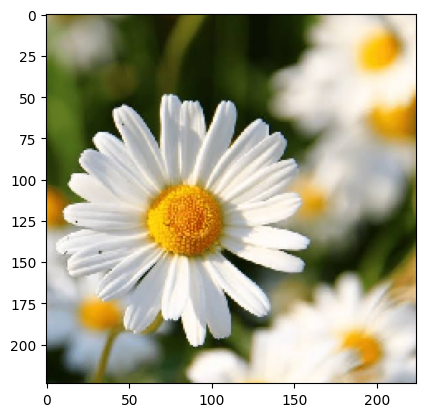

In [51]:
uploaded = files.upload()

for fn in uploaded.keys():
  #prediksi gambar
  path = fn
  img = image.load_img(path, target_size=(224,224))

  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])


  classes = model.predict(images, batch_size=30)
  print(fn)

  print(classes)
  print(labels[np.argmax(classes)])

##Save Model

In [38]:
# Menyimpan model dalam format SavedModel
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

In [40]:
# save to tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

tflite_model_path = f'/content/model.tflite'
tf.io.write_file(tflite_model_path, tflite_model)

Saved artifact at '/tmp/tmp15tqvuih'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_271')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  135585810734720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135584285952480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135584285954592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135584285951600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135584285953184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135584285957232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135584285959520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135584285964272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135584285951072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135584285957584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135584285

In [41]:
!pip install tensorflowjs

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 79.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 110.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 109.2 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully un

In [45]:
model.save('model.keras')

In [46]:
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model

2024-11-29 09:02:01.187944: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732870921.209060   28513 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732870921.215612   28513 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file
